# Experiments 7. Nesterov-Skokov Function

We will minimize

$$f(x) = \frac{1}{4}(1-x_1)^2+\sum\limits_{i=1}^{n-1}\left(x_{i+1}-2x_i^2 + 1\right)^2.$$


In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import timeit
from jax.config import config

In [2]:
from methods import gradf_inexact
from methods import GradientDescent, parse_logs, AdaptiveL, StepSize, AdaptiveNoiseGD
from methods import ConstantStepSize, AdaptiveLdelta

In [3]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 2,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

In [4]:
config.update("jax_enable_x64", True)

In [5]:
path_pics = "../pics/"

In [6]:
def f1(x, n):
    G = 1/4*(1-x[0])**2
    for i in range(n-1):
        G += (x[i+1] - 2 * x[i]**2 +1)**2
    return G.sum()
gradf = jax.grad(f1, argnums=(0,), has_aux=False)
jit_gradf = jax.jit(gradf)
gradf = lambda x: np.hstack([np.array(i.block_until_ready()) for i in jit_gradf(x)])

def get_params(n):
    f = lambda x: f1(x, n)
    gradf = jax.grad(f, argnums=(0,), has_aux=False)
    jit_gradf = jax.jit(gradf)
    gradf = lambda x: np.hstack([np.array(i.block_until_ready()) for i in jit_gradf(x)])
    return gradf, f
gradf, f = get_params(2)
gradf(np.ones(2))

array([0., 0.])

## 1. Noise Distributed on the Unit Sphere

The case when $\xi \sim \mathcal{U}(S_1(0))$

In [9]:
eps_list = [1e-4]

n = 1
n_list = [7]

res = {n:{"delta":[], 
           "iters_adaptL":[], "time_adaptL":[], "adaptL,x0-x*": [], "normg_adaptL": [],
           "iters_exact":[], "time_exact":[], "exact,x0-x*": [], "normg_exact": [],
          "residual_adaptL":[],
          "iters_adaptLdelta":[], "time_adaptLdelta":[], "adaptLdelta,x0-x*": [], "normg_adaptLdelta": []} for n in n_list}
mu_list = {}
number = 10
save_iter = 1
N = 900000
methods = []
np.random.seed(1)
for n in n_list:
    print(n)
    gradf, f = get_params(n)
    w = np.ones(n)
    w[0] *= -1
    print(np.linalg.norm(gradf(w)), f(w))
    for eps in eps_list:
        mu = 1e-6
        Delta = np.sqrt(eps)
        f_inexact = lambda x: f(x) + eps * np.random.uniform(-1, 1)
        res[n]["delta"].append(int(np.log10(Delta)))
        tol = 2*Delta


        grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 1)
        print(eps)
        method = GradientDescent(AdaptiveL(L0=1, Delta=Delta, Lmin=mu/4, delta=eps), name="GD, Delta={}".format(Delta), save_iter=save_iter)
        x = method.solve(w, f_inexact, grad_inexact, tol=tol, max_iter=N)
        g = lambda: GradientDescent(AdaptiveL(L0=1, Delta=Delta, Lmin=mu/4),
                                    return_history=False).solve(w, f_inexact, grad_inexact, tol=tol, max_iter=N)
        methods.append(method)   
        print("\n")
    print("\n\n")

7
1.0 1.0
0.0001







In [28]:
eps_list = [1e-1]

n = 1
n_list = [7]

res = {n:{"delta":[], 
           "iters_adaptL":[], "time_adaptL":[], "adaptL,x0-x*": [], "normg_adaptL": [],
           "iters_exact":[], "time_exact":[], "exact,x0-x*": [], "normg_exact": [],
          "residual_adaptL":[],
          "iters_adaptLdelta":[], "time_adaptLdelta":[], "adaptLdelta,x0-x*": [], "normg_adaptLdelta": []} for n in n_list}
mu_list = {}
number = 10
save_iter = 1
N = 40000
methods = []
np.random.seed(10)
for n in n_list:
    print(n)
    gradf, f = get_params(n)
    w = np.ones(n)
    w[0] *= -1
    print(np.linalg.norm(gradf(w)), f(w))
    for eps in eps_list:
        mu = 1e-6
        Delta = np.sqrt(eps)
        f_inexact = lambda x: f(x) + eps * np.random.uniform(-1, 1)
        res[n]["delta"].append(int(np.log10(Delta)))
        tol = 2*Delta
        tol = 0


        grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 3)
        print(eps)
        method = GradientDescent(AdaptiveL(L0=1, Delta=Delta, Lmin=mu/4, delta=eps), name="GD, Delta={}".format(Delta), save_iter=save_iter)
        x = method.solve(w, f_inexact, grad_inexact, tol=tol, max_iter=N)
        g = lambda: GradientDescent(AdaptiveL(L0=1, Delta=Delta, Lmin=mu/4),
                                    return_history=False).solve(w, f_inexact, grad_inexact, tol=tol, max_iter=N)

        methods.append(method)   
        print("\n")
    print("\n\n")

7
1.0 1.0
0.1







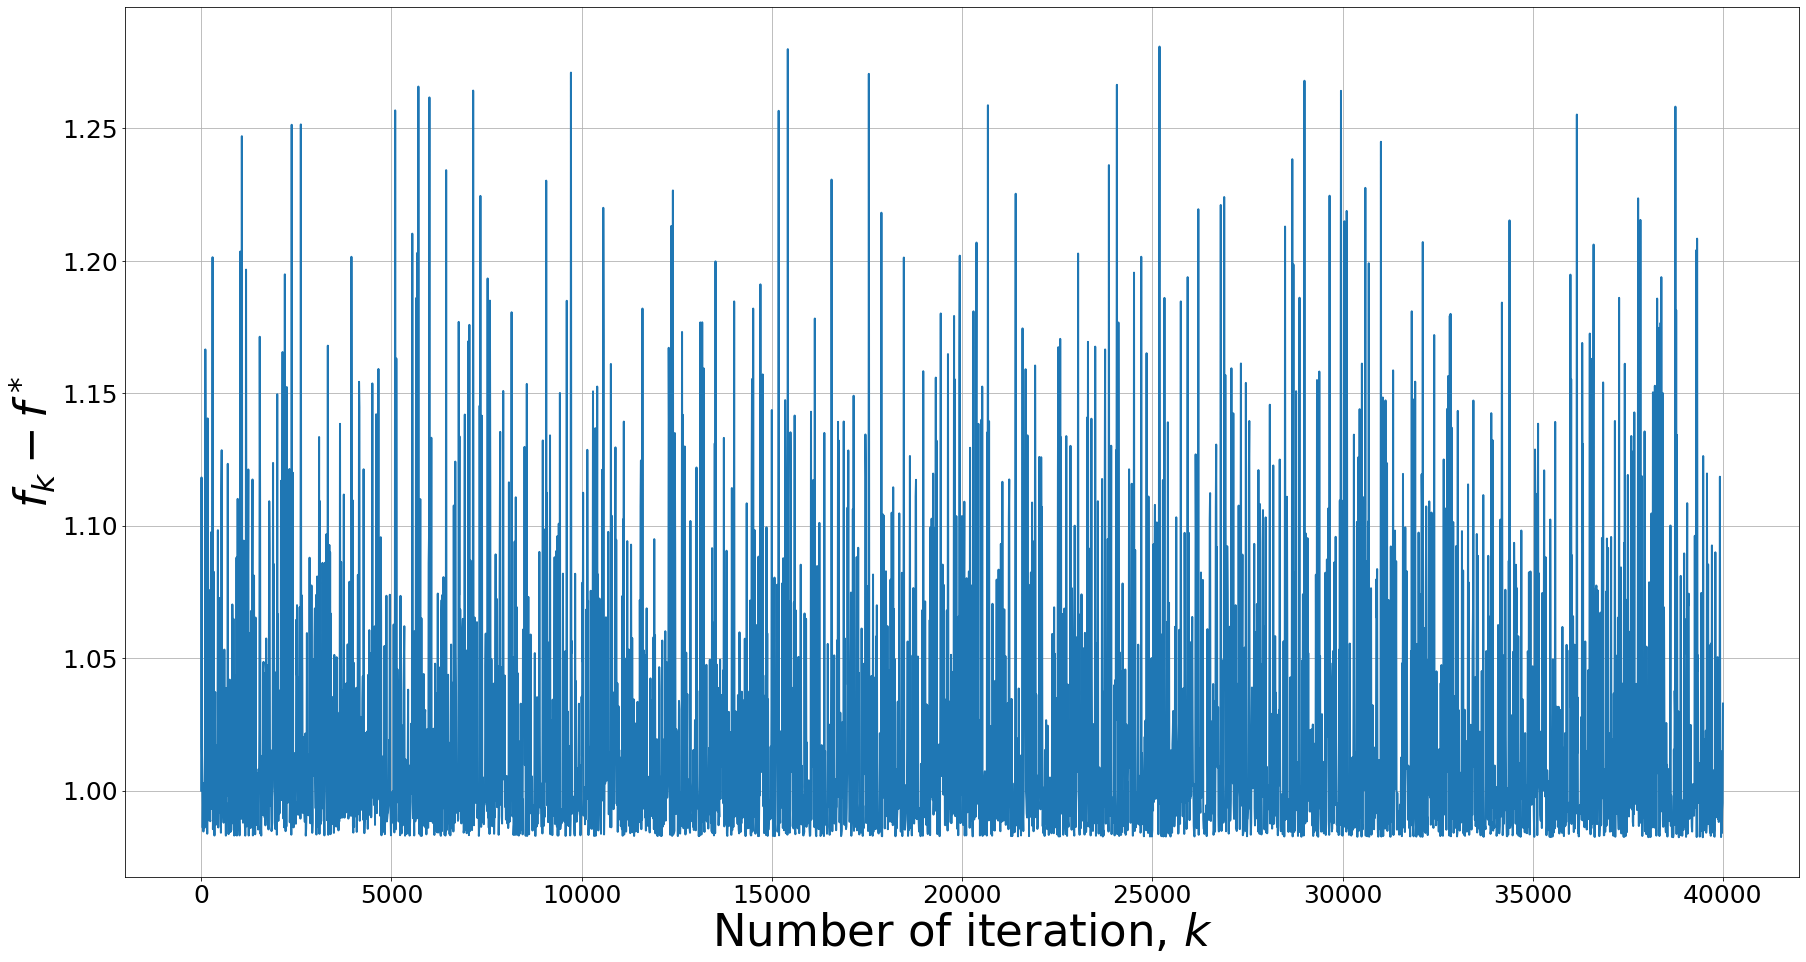

In [36]:
%matplotlib inline
plt.figure(figsize=(30, 16))
k = 10
plt.plot(np.arange(len(method.history))[::k], [f(x) for x, _ in method.history][::k])
plt.ylabel(r"$f_k-f^*$")
plt.xlabel(r"Number of iteration, $k$")
plt.grid()
plt.savefig(os.path.join(path_pics, "Plateau1.png"))

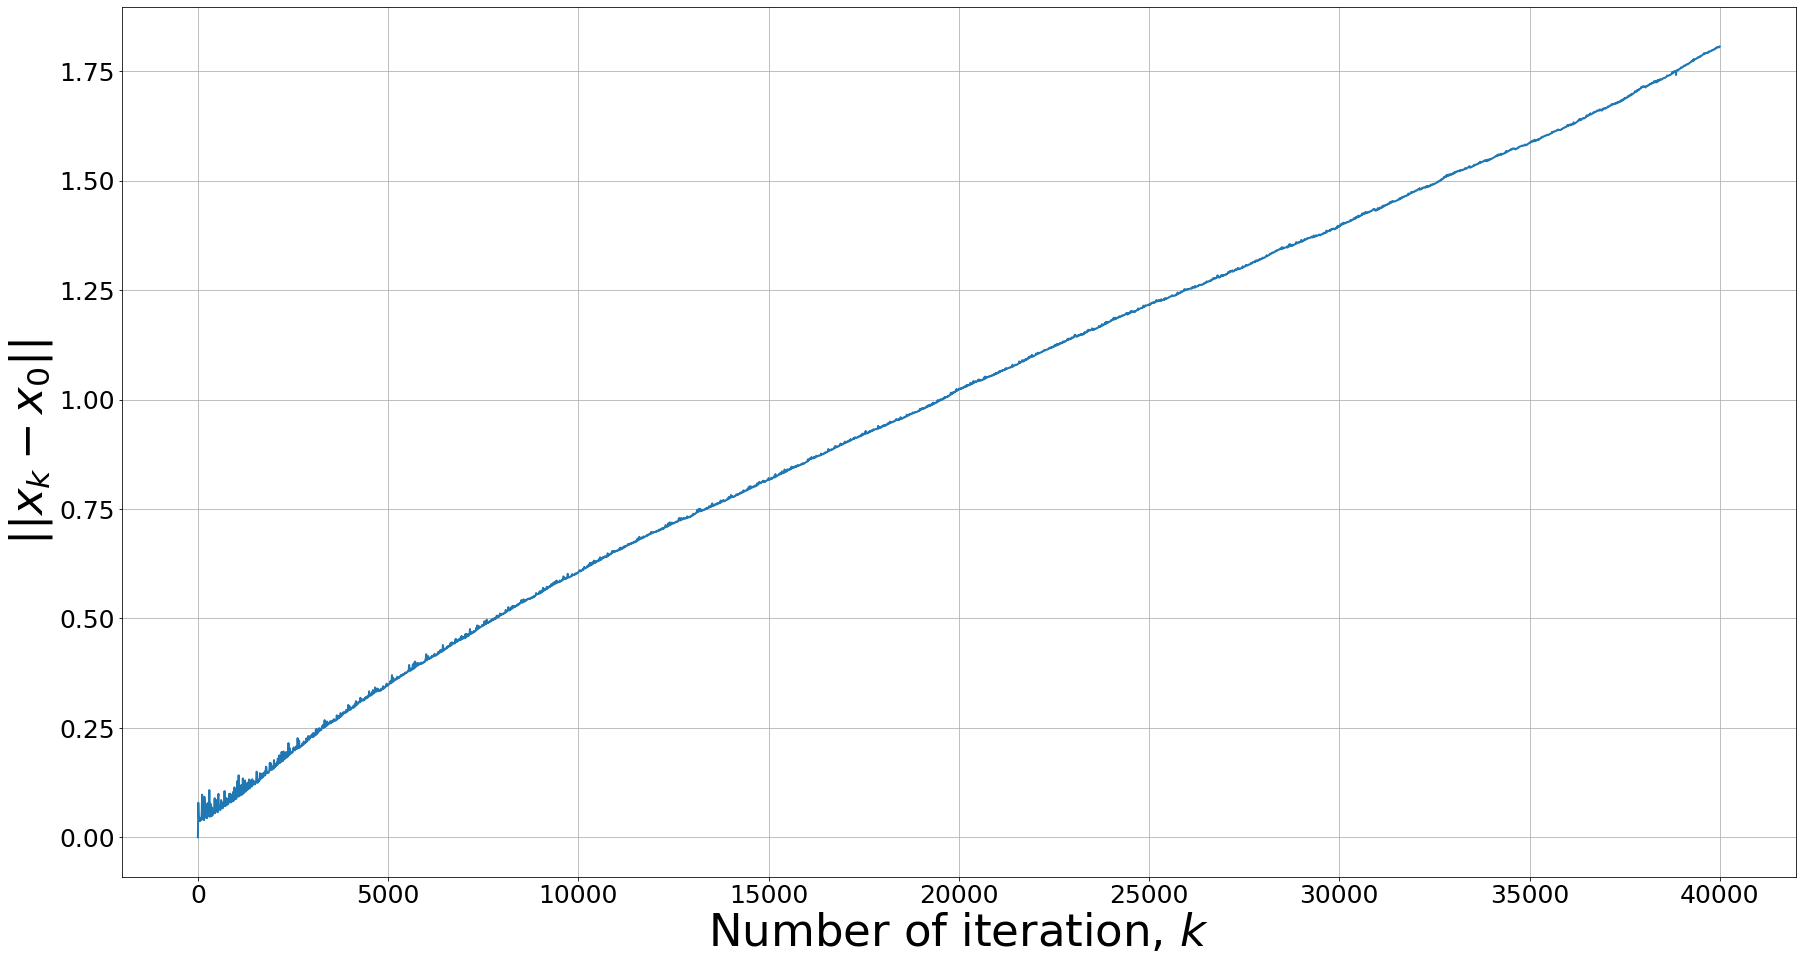

In [37]:
%matplotlib inline
plt.figure(figsize=(30, 16))
k = 10
plt.plot(np.arange(len(method.history))[::k], [np.linalg.norm(x-w) for x, _ in method.history][::k])
plt.ylabel(r"$||x_k-x_0||$")
plt.xlabel(r"Number of iteration, $k$")
plt.grid()
plt.savefig(os.path.join(path_pics, "Plateau2.png"))